In [1]:
import warnings
warnings.filterwarnings("ignore")
import math
import kwant
import tinyarray
import matplotlib
import numpy as np
import numpy.linalg as npl
from matplotlib import pyplot
import ipywidgets

In [659]:
# Pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

def interact(function, **params):
    params_spec = {key: ipywidgets.FloatText(value=value, step=0.05) for key, value in params.items()}
    return ipywidgets.interactive(function, **params_spec)

def make_sample_1D(a0=1, Width=40, t=1.0, Lso=0.06, Lr=0.05, Lv=0.1, Jsd=0.0):
    lat = kwant.lattice.honeycomb(a0, norbs=2)     #honeycomb lattice with lattice constant a0, norbs=2 for spin DOF
    symmetry = kwant.TranslationalSymmetry((1, 0)) #System is periodic in x direction
    sample = kwant.Builder(symmetry)
    A_site, B_site = lat.sublattices               #Read Bravais vectors for A, B sublattices
    sample[(A_site(0,i+1) for i in range(Width))] = +Lv*sigma_0 + Jsd*sigma_z  #On-site(A) energy
    sample[(B_site(0,i) for i in range(Width))]   = -Lv*sigma_0 - Jsd*sigma_z  #On-site(B) energy
    
    #We cannot use sample[lat.neighbors(2)]=1j*Lso*sigma_z to add SOC for NNN hoppings!
    
    for i in range(Width):                             #Zigzag edge
        if i > 0:
            sample[A_site(0,i+1), A_site(0,i)] = 1j*Lso*sigma_z  #SOC
            sample[A_site(1,i), A_site(0,i+1)] = 1j*Lso*sigma_z  #SOC
            sample[B_site(0,i), B_site(0,i-1)] = -1j*Lso*sigma_z #SOC
            sample[B_site(1,i-1), B_site(0,i)] = -1j*Lso*sigma_z #SOC
            sample[A_site(0,i), B_site(0,i)] = t*sigma_0+1j*Lr*sigma_x #Rashba
            
        sample[A_site(0,i+1), A_site(1,i+1)] = 1j*Lso*sigma_z  #SOC    
        sample[B_site(0,i), B_site(1,i)] = -1j*Lso*sigma_z     #SOC
        sample[A_site(0,i+1), B_site(0,i)] = t*sigma_0+1j*Lr*(-0.5*sigma_x+np.sqrt(3)*sigma_y/2) #Rashba
        sample[A_site(0,i+1), B_site(1,i)] = t*sigma_0+1j*Lr*(-0.5*sigma_x-np.sqrt(3)*sigma_y/2) #Rashba
        #Remember to set normal spin-independent NN hopping in the Rashba SOC
        
    return sample


def sample_geometry(Width=10,Length=30):
    lat = kwant.lattice.honeycomb(1, norbs=2)     
    sample = kwant.Builder()
    A_site, B_site = lat.sublattices               
    for j in range(Length):
        sample[(A_site(j,i+1) for i in range(Width))] = 1
        sample[(B_site(j,i) for i in range(Width))]   = 1
    sample[lat.neighbors(1)] = 1
    return sample


def plot_band_interactive(SOC=0.06,Rashba=0.05,Staggered=0.1,exchange=0.0):

    KM_model = make_sample_1D(a0=1, Width=40, t=1, Lso=SOC, Lr=Rashba, Lv=Staggered, Jsd=exchange).finalized()
    kwant.plotter.bands(KM_model, momenta=np.linspace(0, 2*np.pi, 401), show=False);
    pyplot.xlabel("Momentum $k_x$ [$a_0^{-1}$]")
    pyplot.ylabel("Energy [t]")
    pyplot.ylim(-1,1)
    pyplot.show()

In [149]:
interact(plot_band_interactive,tN=1.0,SOC=0.06,Rashba=0.05,Staggered=0.1, exchange=0.1)

interactive(children=(FloatText(value=0.06, description='SOC', step=0.05), FloatText(value=0.05, description='…

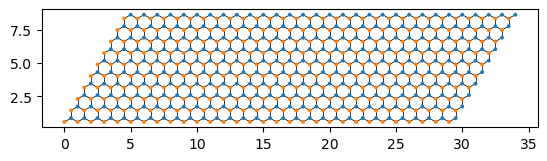

In [148]:
kwant.plot(sample_geometry(Width=10,Length=30), file="geometry.pdf")
#pyplot.show()

1001
160


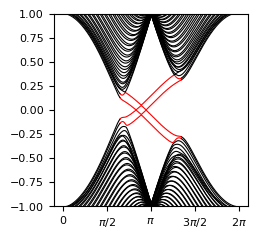

In [668]:
KM_band  = make_sample_1D(a0=1, Width=40, t=1, Lso=0.05, Lr=0.025, Lv=0.05, Jsd=0.1).finalized()
bands    = kwant.physics.Bands(KM_band)
momenta  = np.array(np.linspace(0, 2*np.pi, 1001))
energies = np.array([bands(kx) for kx in momenta])
print(len(energies))
print(len(energies[0]))

energies_transposed = np.transpose(energies)
data_to_save = np.vstack((momenta, energies_transposed))
np.savetxt("band_data_QSH.csv", data_to_save, delimiter=",")

pyplot.figure(figsize=(2.5, 2.5))
for index, energy in enumerate(energies.T):
    if index in [78, 79, 80, 81]:
        mask1 = (momenta >  1.3* np.pi/2) & (momenta <  0.9*3*np.pi/2)
        mask2 = momenta  <=  1.3* np.pi/2
        mask3 = momenta  >=  0.9* 3*np.pi/2
        pyplot.plot(momenta[mask1], energy[mask1], color='red',   linewidth=0.8)
        pyplot.plot(momenta[mask2], energy[mask2], color='black', linewidth=0.8)
        pyplot.plot(momenta[mask3], energy[mask3], color='black', linewidth=0.8)
    else:
        pyplot.plot(momenta, energy, color='black', linewidth=0.8)
        

#pyplot.xlabel("$k_x$/$a_0$")
#pyplot.ylabel("E / t")
pyplot.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
pyplot.ylim(-1,1)
pyplot.xticks(fontsize=8)
pyplot.yticks(fontsize=8)
#pyplot.savefig("fig1.pdf")
pyplot.show()

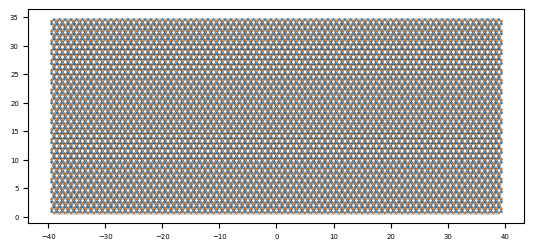

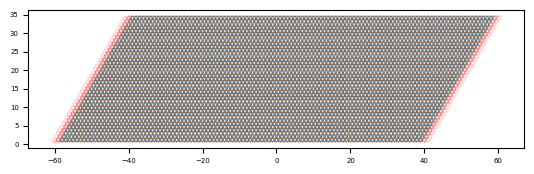

In [669]:
a0=1
Width=40
length = 40
t=1.0
Lso=0.05*t
Lr=0.025*t
Lv=0.05*t
Jsd=0.1*t

lat = kwant.lattice.honeycomb(a0, norbs=2)     #honeycomb lattice with lattice constant a0, norbs=2 for spin DOF
symmetry = kwant.TranslationalSymmetry((-1, 0)) #System is periodic in -x direction
sample = kwant.Builder(symmetry)
A_site, B_site = lat.sublattices               #Read Bravais vectors for A, B sublattices
sample[(A_site(0,i+1) for i in range(Width))] = +Lv*sigma_0 + Jsd*sigma_z  #On-site(A) energy
sample[(B_site(0,i) for i in range(Width))]   = -Lv*sigma_0 - Jsd*sigma_z  #On-site(B) energy
    
    
for i in range(Width):                             #Zigzag edge
    if i > 0:
        sample[A_site(0,i+1), A_site(0,i)] = 1j*Lso*sigma_z  #SOC
        sample[A_site(1,i), A_site(0,i+1)] = 1j*Lso*sigma_z  #SOC
        sample[B_site(0,i), B_site(0,i-1)] = -1j*Lso*sigma_z #SOC
        sample[B_site(1,i-1), B_site(0,i)] = -1j*Lso*sigma_z #SOC
        sample[A_site(0,i), B_site(0,i)] = t*sigma_0+1j*Lr*sigma_x #Rashba
            
    sample[A_site(0,i+1), A_site(1,i+1)] = 1j*Lso*sigma_z  #SOC    
    sample[B_site(0,i), B_site(1,i)] = -1j*Lso*sigma_z     #SOC
    sample[A_site(0,i+1), B_site(0,i)] = t*sigma_0+1j*Lr*(-0.5*sigma_x+np.sqrt(3)*sigma_y/2) #Rashba
    sample[A_site(0,i+1), B_site(1,i)] = t*sigma_0+1j*Lr*(-0.5*sigma_x-np.sqrt(3)*sigma_y/2) #Rashba


left_lead = sample

def scatter_shape(site):
    x, y = abs(site.pos)
    return x < length

scatter = kwant.Builder()
scatter.fill(left_lead, scatter_shape, (0, 0));
kwant.plot(scatter);

scatter.attach_lead(left_lead)
scatter.attach_lead(left_lead.reversed())
kwant.plot(scatter);
scatter = scatter.finalized()

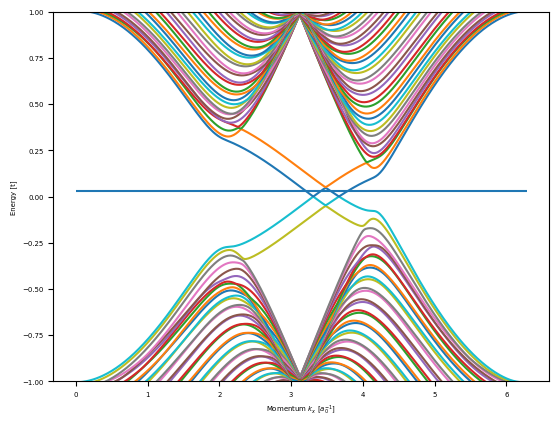

In [682]:
kwant.plotter.bands(scatter.leads[0], momenta=np.linspace(0, 2*np.pi, 401), show=False)
pyplot.ylim(-1, 1)
pyplot.xlabel("Momentum $k_x$ [$a_0^{-1}$]")
pyplot.ylabel("Energy [t]")
pyplot.hlines(0.03,0,2*np.pi)
pyplot.show()

In [683]:
# get scattering wave functions at E=0
wf = kwant.wave_function(scatter, energy=0.03)

# prepare density operators
sigma_z = np.array([[1, 0], [0, -1]])
onsite_density_matrices = {A_site:  sigma_0, B_site: sigma_0}
onsite_spin_matrices = {A_site:  sigma_z, B_site: sigma_z}
prob_density = kwant.operator.Density(scatter, onsite_density_matrices)
spin_density = kwant.operator.Density(scatter, onsite_spin_matrices)

# calculate expectation values and plot them
#rho_sz_left = sum(spin_density(psi) for psi in wf(0))  # states from left lead
#rho_sz_right = sum(spin_density(psi) for psi in wf(1))  # states from right lead

rho_sz_right = spin_density(wf(1)[0])  # states from right lead of imcoming (negative v) in mode 0
rho_sz_left  = spin_density(wf(0)[0])  # states from lef lead of imcoming (negative v) in mode 0

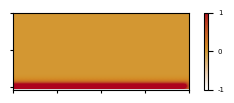

In [684]:
fig, ax1 = pyplot.subplots(1, 1, figsize=(4, 1))

kwant.plotter.density(scatter, rho_sz_right/max(np.abs(rho_sz_right)), ax=ax1, vmin=-1, vmax=1)

ax1.tick_params(direction='out')
ax1.tick_params(axis='both', which='major', length=2)
pyplot.rcParams.update({'font.size': 5})
ax1.set_xlim([-length, length])
ax1.set_ylim([0, 35])
ax1.set_xticks([-40,-20, 0, 20, 40],['', '', '', '', ''])
ax1.set_yticks([1,18,35],['','',''])
#ax1.set_title('Spin density')
#ax1.set_xlabel('Length (N)')
#ax1.set_ylabel('Width (N)')

im = [obj for obj in ax.get_children() if isinstance(obj, matplotlib.image.AxesImage)][0]
cbar = fig.colorbar(im, ax=ax1)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-1', '0', '1'])
cbar.ax.tick_params(labelsize=5)

pyplot.show()
#fig.savefig("QAH(right lead mode 0, E=0.03).pdf", bbox_inches='tight')

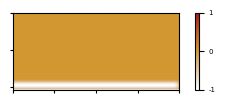

In [685]:
fig, ax1 = pyplot.subplots(1, 1, figsize=(4, 1))

kwant.plotter.density(scatter, rho_sz_left/max(np.abs(rho_sz_left)), ax=ax1, vmin=-1, vmax=1)

ax1.tick_params(direction='out')
ax1.tick_params(axis='both', which='major', length=2)
pyplot.rcParams.update({'font.size': 5})
ax1.set_xlim([-length, length])
ax1.set_ylim([-1, 36])
ax1.set_xticks([-40,-20, 0, 20, 40],['', '', '', '', ''])
ax1.set_yticks([0,18,36],['','',''])
#ax1.set_title('Spin density')
#ax1.set_xlabel('Length (N)')
#ax1.set_ylabel('Width (N)')

im = [obj for obj in ax.get_children() if isinstance(obj, matplotlib.image.AxesImage)][0]
cbar = fig.colorbar(im, ax=ax1)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-1', '0', '1'])
cbar.ax.tick_params(labelsize=5)

pyplot.show()
#fig.savefig("QAH(left lead mode 0, E=0.03).pdf", bbox_inches='tight')

In [640]:
print(len(wf(0)))

1


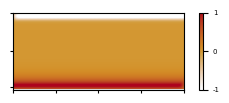

In [610]:
# get scattering wave functions at E=0
wf = kwant.wave_function(scatter, energy=0.08)

# prepare density operators
sigma_z = np.array([[1, 0], [0, -1]])
onsite_spin_matrices = {A_site:  sigma_z, B_site: sigma_z}
current = kwant.operator.Current(scatter)
spin_density = kwant.operator.Density(scatter, onsite_spin_matrices)

# calculate expectation values and plot them
rho_sz_left = sum(spin_density(psi) for psi in wf(0))  # states from left lead
rho_sz_right = sum(spin_density(psi) for psi in wf(1))  # states from right lead


fig, ax1 = pyplot.subplots(1, 1, figsize=(4, 1))

kwant.plotter.density(scatter, rho_sz_right/max(np.abs(rho_sz_right)), ax=ax1, vmin=-1, vmax=1)

ax1.tick_params(direction='out')
ax1.tick_params(axis='both', which='major', length=2)
pyplot.rcParams.update({'font.size': 5})
ax1.set_xlim([-length, length])
ax1.set_ylim([0, 36])
ax1.set_xticks([-40,-20, 0, 20, 40],['', '', '', '', ''])
ax1.set_yticks([1,18,36],['','',''])
#ax1.set_title('Spin density')
#ax1.set_xlabel('Length (N)')
#ax1.set_ylabel('Width (N)')

im = [obj for obj in ax.get_children() if isinstance(obj, matplotlib.image.AxesImage)][0]
cbar = fig.colorbar(im, ax=ax1)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-1', '0', '1'])
cbar.ax.tick_params(labelsize=5)

pyplot.show()

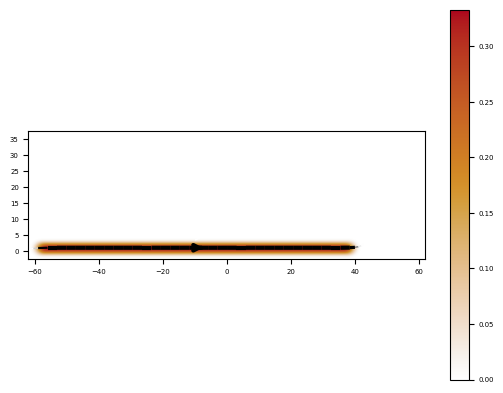

In [612]:
kwant.plotter.current(scatter, current(wf(0)[1]))
pyplot.show()